# **1. Import Modul Yang Diperlukan**

In [ ]:
# import library sistem
import os
import json
import time
import shutil
import pathlib
import itertools
from google.colab import drive
drive.mount('/content/drive/')

# import alat penanganan data
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import library Deep learning
import tensorflow as tf
print("versi tensorflow = " + tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('semua modul dimuat')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
versi tensorflow = 2.15.0
semua modul dimuat


# **2. Pra-Pemrosesan Data**

#### 2.1. Membuat Data Frame dari Dataset

--- Isi List filepaths dan labels ---
                                           filepaths  labels
0  /content/drive/My Drive/Dataset Skripsi_4 Kela...  kunyit
1  /content/drive/My Drive/Dataset Skripsi_4 Kela...  kunyit
2  /content/drive/My Drive/Dataset Skripsi_4 Kela...  kunyit
3  /content/drive/My Drive/Dataset Skripsi_4 Kela...  kunyit
4  /content/drive/My Drive/Dataset Skripsi_4 Kela...  kunyit

--- Isi dataset dari setiap kelas ---
labels
jahe         1315
temulawak    1232
kunyit       1016
lengkuas      928
Name: count, dtype: int64


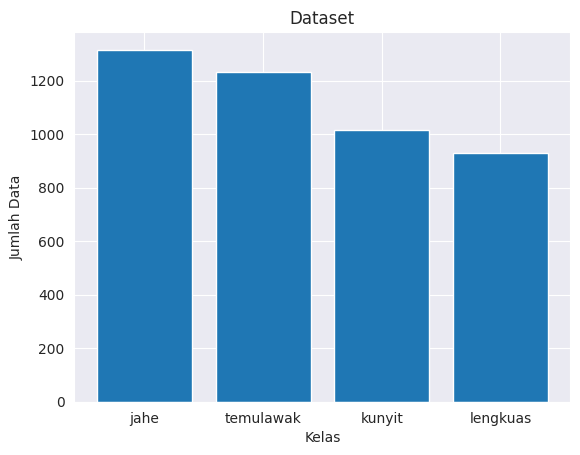

In [ ]:
# Folder data pelatihan
data_dir = "/content/drive/My Drive/Dataset Skripsi_4 Kelas"

# Mendapatkan daftar kelas
classes = os.listdir(data_dir)

# Menyimpan jalur file dan label
filepaths = []
labels = []

# Mengumpulkan data dari setiap kelas
for kelas in classes:
    # Membangun jalur folder kelas
    class_dir = os.path.join(data_dir, kelas)
    # Mendapatkan daftar file dalam kelas
    files = os.listdir(class_dir)
    # Menambahkan jalur file dan label
    for f in files:
        filepaths.append(os.path.join(class_dir, f))
        labels.append(kelas)

# Membuat DataFrame
df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

# Menampilkan beberapa baris pertama
print("--- Isi List filepaths dan labels ---")
print(df.head())

# Menampilkan jumlah file per kelas
print("\n--- Isi dataset dari setiap kelas ---")
print(df["labels"].value_counts())

# Membuat bar plot
class_counts = df["labels"].value_counts()
plt.bar(class_counts.index, class_counts)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Dataset")
plt.show()

#### 2.2. Split Data Frame

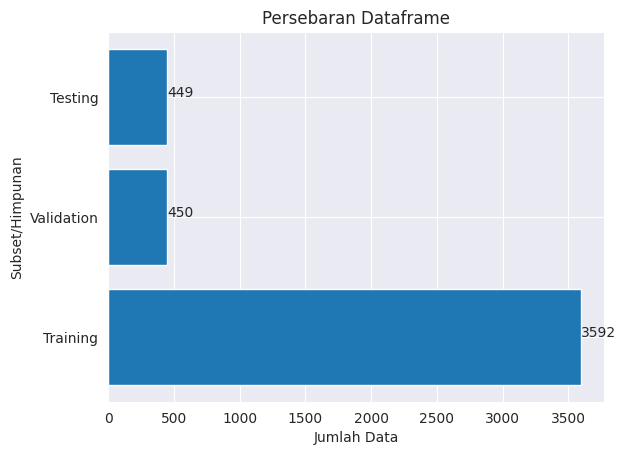

In [ ]:
# Mendefinisikan proporsi dataframe
train_split = 0.8
test_split = 0.5

# Membagi dataframe menjadi training 80% dan dummy 20%
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

# Membagi dummy dataframe menjadi testing 50% dan validasi 50%
test_df, valid_df = train_test_split(dummy_df, train_size=test_split, shuffle=True, random_state=123)

# Menghitung jumlah dataframe di setiap set
train_count = int(len(train_df))
valid_count = int(len(valid_df))
test_count = int(len(test_df))

# Membuat bar plot horizontal
plt.barh(["Training", "Validation", "Testing"], [train_count, valid_count, test_count])
for i, count in enumerate([train_count, valid_count, test_count]):
  plt.text(count, i, f"{count}")
plt.ylabel("Subset/Himpunan")
plt.xlabel("Jumlah Data")
plt.title("Persebaran Dataframe")
plt.show()

#### 2.3. Augmentasi Data Frame

In [ ]:
# Parameter
height = 256
width = 256
channels = 3
batch_size = 16

# Bentuk gambar
img_shape = (height, width, channels)
img_size = (height, width)

# Batch size untuk data testing
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Mendefinisikan ImageDataGenerator
image_datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
image_datagen_validtes = ImageDataGenerator(rescale=1./255)

# Generator data
train_gen = image_datagen_train.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

valid_gen = image_datagen_validtes.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size)

test_gen = image_datagen_validtes.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size)

# Mendapatkan informasi kelas
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
print("\n--- Kelas Dalam Dataset ---")
print(classes)

Found 3592 validated image filenames belonging to 4 classes.
Found 450 validated image filenames belonging to 4 classes.
Found 449 validated image filenames belonging to 4 classes.

--- Kelas Dalam Dataset ---
['jahe', 'kunyit', 'lengkuas', 'temulawak']


#### 2.4. Sampel Gambar Data Latih

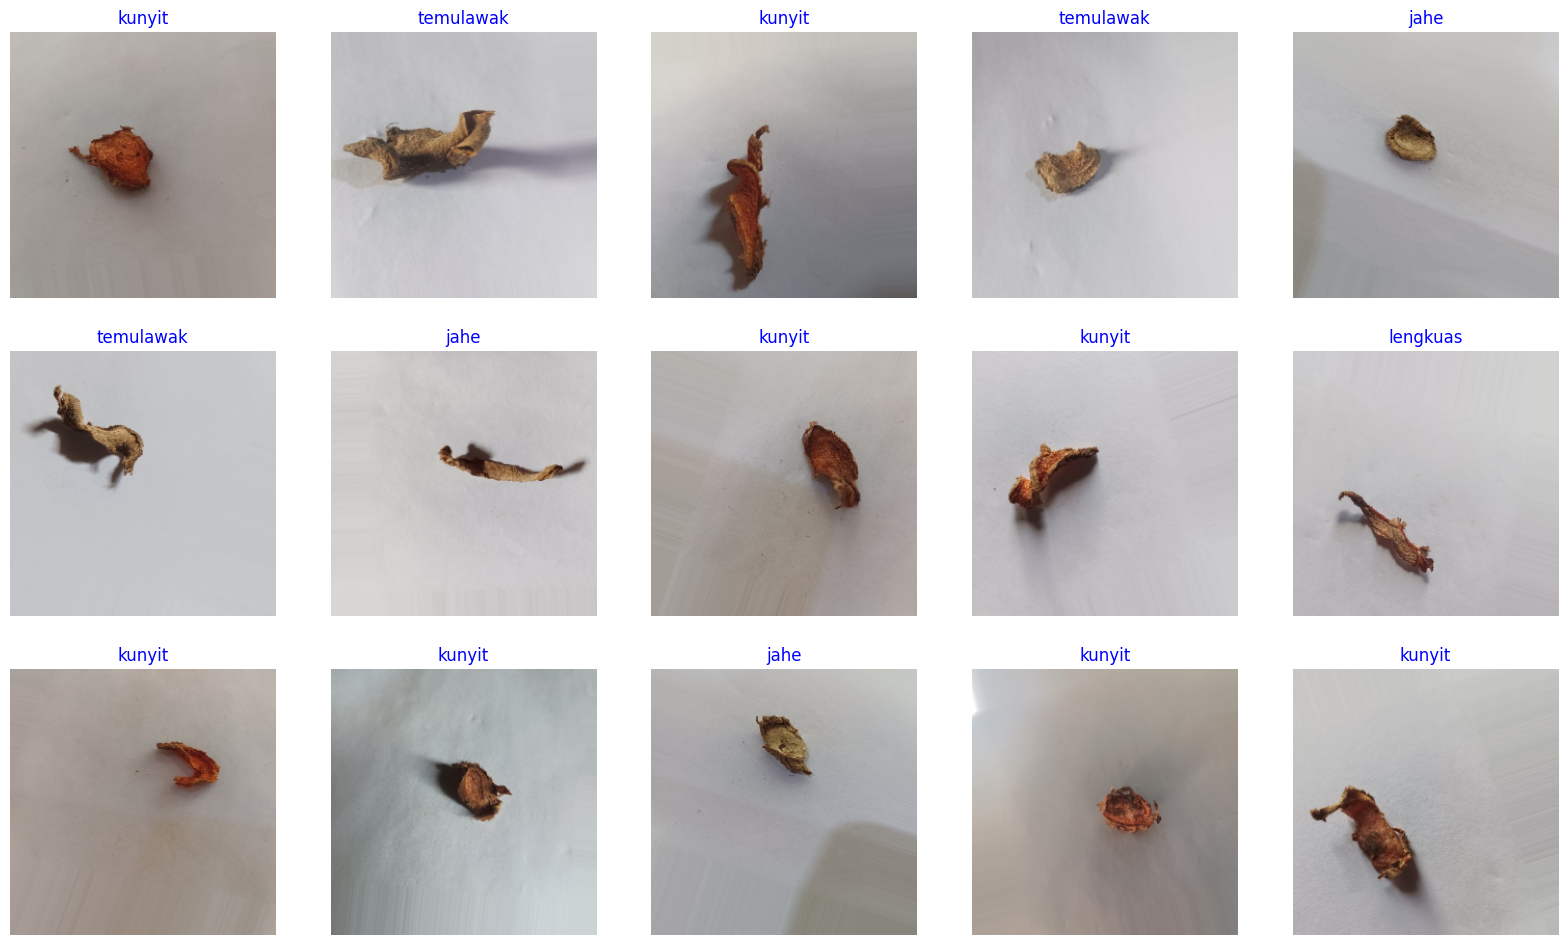

In [ ]:
def show_image_samples(gen, num_images=25):
  """Menampilkan contoh gambar dari generator data."""

  # Mendapatkan kelas dan gambar
  classes = list(gen.class_indices.keys())
  images, labels = next(gen)

  # Menentukan jumlah gambar yang ditampilkan
  num_images = min(num_images, len(images))

  # Membuat plot
  plt.figure(figsize=(20, 20))
  for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image)
    # Mendapatkan nama kelas
    index = np.argmax(labels[i])
    class_name = classes[index]
    # Menambahkan judul dan mematikan sumbu
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
  plt.show()

# Menampilkan contoh gambar dari data latih
show_image_samples(train_gen, num_images=15)

# **3. Pemodelan**

#### 3.1 Pre-trained DenseNet dan Custom Layer

In [ ]:
# Pre-trained model DenseNet169
densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=img_shape)
# densenet169.trainable = False

# Menambahkan layer klasifikasi
model = tf.keras.Sequential([
    densenet169,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(units=len(classes), activation='softmax')
])

In [ ]:
# optimizer dan crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate=0.0001),
              metrics=['accuracy'])
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 8, 8, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1024)              1704960   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                        

#### 3.2 Callbacks
<br>
Callback : berguna untuk membantu mengoptimalkan pelatihan model <br>
Contoh: menghentikan pelatihan model setelah waktu tertentu, menghentikan pelatihan jika tidak ada peningkatan akurasi, dan seterusnya.

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()  # Memanggil konstruktor class induk (keras.callbacks.Callback)

        # Parameter yang diterima
        self.model = model
        self.patience = patience  # Jumlah epoch untuk menunggu perbaikan metrik sebelum menurunkan learning rate
        self.stop_patience = stop_patience  # Jumlah penurunan learning rate yang diizinkan sebelum menghentikan pelatihan
        self.threshold = threshold  # Akurasi training minimum untuk menurunkan learning rate berdasarkan akurasi training
        self.factor = factor  # Faktor pengali untuk menurunkan learning rate
        self.batches = batches  # Jumlah batch dalam satu epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch  # Epoch tertentu untuk menanyakan pengguna apakah ingin melanjutkan pelatihan (dapat diubah menjadi None untuk menonaktifkan)

        # Variabel internal callback
        self.count = 0  # Berapa kali learning rate diturunkan tanpa peningkatan
        self.stop_count = 0  # Berapa kali learning rate sudah diturunkan tanpa peningkatan untuk menghentikan pelatihan lebih awal
        self.best_epoch = 1  # Epoch dengan loss terendah
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Mendapatkan learning rate awal dan menyimpannya
        self.highest_tracc = 0.0  # Set akurasi training tertinggi menjadi 0 awalnya
        self.lowest_vloss = np.inf  # Set loss validasi terendah ke tak terhingga awalnya
        self.best_weights = self.model.get_weights()  # Set bobot terbaik ke bobot awal model
        self.initial_weights = self.model.get_weights()  # Simpan bobot awal untuk dipulihkan jika perlu

    # Fungsi dipanggil ketika pelatihan dimulai
    def on_train_begin(self, logs=None):
        msg = 'Apakah Anda ingin mengontrol proses pelatihan [y/n] ?'
        print(msg)
        ans = input('')

        # Meminta izin pengguna untuk menghentikan pelatihan
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        # Mencetak header tabel untuk menampilkan informasi epoch, loss, akurasi, dll.
        msg = '{0:<9s}{1:<10s}{2:<10s}{3:<10s}{4:<10s}{5:<10s}{6:<10s}{7:<11s}{8:<11s}{9:<10s}'.format('Epoch', 'Loss', 'Akurasi', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', 'Improv(%)', 'Durasi')
        print(msg)
        self.start_time = time.time()  # Mencatat waktu awal pelatihan

    # Fungsi dipanggil ketika pelatihan selesai
    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time  # Menghitung durasi pelatihan
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'Waktu pelatihan yang dibutuhkan adalah {str(hours)} jam, {minutes:4.1f} menit, {seconds:4.2f} detik'
        print(msg)

        # Mengatur bobot model ke bobot terbaik yang disimpan selama pelatihan
        self.model.set_weights(self.best_weights)

    # Fungsi dipanggil pada setiap akhir batch
    def on_train_batch_end(self, batch, logs=None):
        # Mendapatkan akurasi dan loss batch
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # Mencetak akurasi dan loss batch secara berkelanjutan pada baris yang sama (lanjutan)
        msg = '{0:20s}memproses batch {1:} dari {2:5s}- akurasi= {3:5.3f} - loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')  # Mencetak di posisi kursor yang sama tanpa pindah baris

    # Fungsi dipanggil pada awal setiap epoch
    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()  # Mencatat waktu awal epoch

    # Fungsi dipanggil pada akhir setiap epoch
    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start  # Menghitung durasi epoch

        # Mendapatkan learning rate saat ini dan akurasi training/validasi serta loss training/validasi dari epoch tersebut
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # Mendapatkan learning rate saat ini
        current_lr = lr
        acc = logs.get('accuracy')  # Mendapatkan akurasi training
        v_acc = logs.get('val_accuracy')  # Mendapatkan akurasi validasi
        loss = logs.get('loss')  # Mendapatkan loss training untuk epoch ini
        v_loss = logs.get('val_loss')  # Mendapatkan loss validasi untuk epoch ini

        # Menyesuaikan Learning Rate:
        if acc < self.threshold:  # Jika akurasi training di bawah threshold (tentukan akurasi minimum)
            monitor = 'accuracy'  # Monitor akurasi training
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc  # Hitung peningkatan akurasi training

            if acc > self.highest_tracc:  # Jika akurasi training meningkat di epoch ini
                self.highest_tracc = acc  # Set akurasi training tertinggi baru
                self.best_weights = self.model.get_weights()  # Simpan bobot dengan akurasi training tertinggi
                self.count = 0  # Reset counter karena akurasi training meningkat
                self.stop_count = 0  # Reset penghitung penurunan learning rate karena akurasi training meningkat

                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                    self.best_epoch = epoch + 1  # Catat epoch dengan loss validasi terendah

            else:  # Akurasi training tidak meningkat
                # Periksa apakah akurasi training tidak meningkat selama 'patience' epoch terakhir
                if self.count >= self.patience - 1:  # Jika ya, maka perlu menurunkan learning rate
                    lr = lr * self.factor  # Turunkan learning rate dengan faktor tertentu
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # Set learning rate baru ke optimizer
                    self.count = 0  # Reset counter
                    self.stop_count = self.stop_count + 1  # Hitung jumlah penurunan learning rate
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                    else:
                        self.count = self.count + 1  # Jika loss validasi tidak menurun, naikkan counter

        else:  # Akurasi training di atas threshold, maka monitor loss validasi
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:  # Jika loss validasi menurun
                self.lowest_vloss = v_loss  # Update loss validasi terendah
                self.best_weights = self.model.get_weights()  # Simpan bobot dengan loss validasi terendah
                self.count = 0  # Reset counter karena loss validasi menurun
                self.stop_count = 0
                self.best_epoch = epoch + 1  # Catat epoch dengan loss validasi terendah

            else:  # Loss validasi tidak menurun
                if self.count >= self.patience - 1:  # Jika loss validasi tidak menurun selama 'patience' epoch terakhir
                    lr = lr * self.factor  # Turunkan learning rate dengan faktor tertentu
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # Set learning rate baru ke optimizer
                    self.stop_count = self.stop_count + 1  # Hitung jumlah penurunan learning rate
                    self.count = 0  # Reset counter

                else:
                    self.count = self.count + 1  # Jika loss validasi tidak menurun, naikkan counter

            if acc > self.highest_tracc:
                self.highest_tracc = acc

        # Mencetak informasi epoch, loss, akurasi, learning rate, dan lainnya
        msg = f'{str(epoch + 1):<3s}/{str(self.epochs):4s} {loss:<10.3f}{acc * 100:<10.3f}{v_loss:<10.5f}{v_acc * 100:<10.3f}{current_lr:<10.5f}{lr:<10.5f}{monitor:<11s}{pimprov:<11.2f}{duration:<10.2f}'
        print(msg)

        # Early Stopping:
        if self.stop_count > self.stop_patience - 1:  # Periksa apakah learning rate sudah disesuaikan 'stop_patience' kali tanpa perbaikan
            msg = f'Pelatihan dihentikan pada epoch {epoch + 1} setelah {self.stop_patience} penurunan learning rate tanpa peningkatan'
            print(msg)
            self.model.stop_training = True  # Hentikan pelatihan lebih awal

        else:
            # Menanyakan pengguna untuk melanjutkan pelatihan (opsional)
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'Masukkan S untuk menghentikan pelatihan atau masukkan bilangan bulat untuk jumlah epoch yang akan dijalankan'
                    print(msg)

                    ans = input('')
                    if ans == 'S' or ans == 's':
                        msg = f'Pelatihan dihentikan pada epoch {epoch + 1} karena masukkan pengguna'
                        print(msg)
                        self.model.stop_training = True  # Hentikan pelatihan

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'Pelatihan akan dilanjutkan hingga epoch {str(self.ask_epoch)}'
                            print(msg)

                            # Mencetak header tabel untuk epoch selanjutnya
                            msg = '{0:<9s}{1:<10s}{2:<10s}{3:<10s}{4:<10s}{5:<10s}{6:<10s}{7:<11s}{8:<11s}{9:<10s}'.format('Epoch', 'Loss', 'Akurasi', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', 'Improv(%)', 'Durasi')
                            print(msg)

                        except Exception:
                            print('Input tidak valid')

#### 3.3 Parameter Callback

In [ ]:
# Parameter pelatihan
batch_size = 16     # Jumlah sampel dalam setiap batch untuk pelatihan
epochs = 100        # Jumlah keseluruhan epoch dalam pelatihan
patience = 3        # Jumlah epoch untuk menunggu perbaikan metrik sebelum menurunkan learning rate
stop_patience = 10  # Jumlah epoch untuk menunggu perbaikan metrik sebelum menghentikan pelatihan lebih awal
threshold = 0.9     # Jika akurasi training < threshold, monitor akurasi training, sebaliknya monitor loss validasi
factor = 0.5        # Faktor pengali untuk menurunkan learning rate
ask_epoch = 5       # Epoch tertentu untuk menanyakan pengguna apakah ingin melanjutkan pelatihan (dapat diubah menjadi None untuk menonaktifkan)

# Menghitung jumlah batch pelatihan per epoch
batches = int(np.ceil(len(train_gen.labels) / batch_size))

# Membangun callback untuk monitoring dan early stopping
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

#### 3.4 Pelatihan Model

In [ ]:
# Menjalankan training model dengan callback
history = model.fit(train_gen, epochs=epochs, verbose=0, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)

Apakah Anda ingin mengontrol proses pelatihan [y/n] ?
y
Epoch    Loss      Akurasi   V_loss    V_acc     LR        Next LR   Monitor    Improv(%)  Durasi    
1  /100  0.340     88.335    0.74194   72.444    0.00010   0.00010   accuracy   0.00       1090.21   
2  /100  0.086     97.244    0.09719   96.000    0.00010   0.00010   val_loss   86.90      97.82     
3  /100  0.062     97.912    0.03509   99.333    0.00010   0.00010   val_loss   63.90      100.54    
4  /100  0.043     98.385    0.01526   99.778    0.00010   0.00010   val_loss   56.51      97.95     
5  /100  0.037     98.775    0.04970   98.667    0.00010   0.00010   val_loss   -225.63    97.80     
Masukkan S untuk menghentikan pelatihan atau masukkan bilangan bulat untuk jumlah epoch yang akan dijalankan
5
Pelatihan akan dilanjutkan hingga epoch 10
Epoch    Loss      Akurasi   V_loss    V_acc     LR        Next LR   Monitor    Improv(%)  Durasi    
6  /100  0.029     99.109    0.01586   99.556    0.00010   0.00010   val_los

#### 3.5 Performa Pelatihan Model

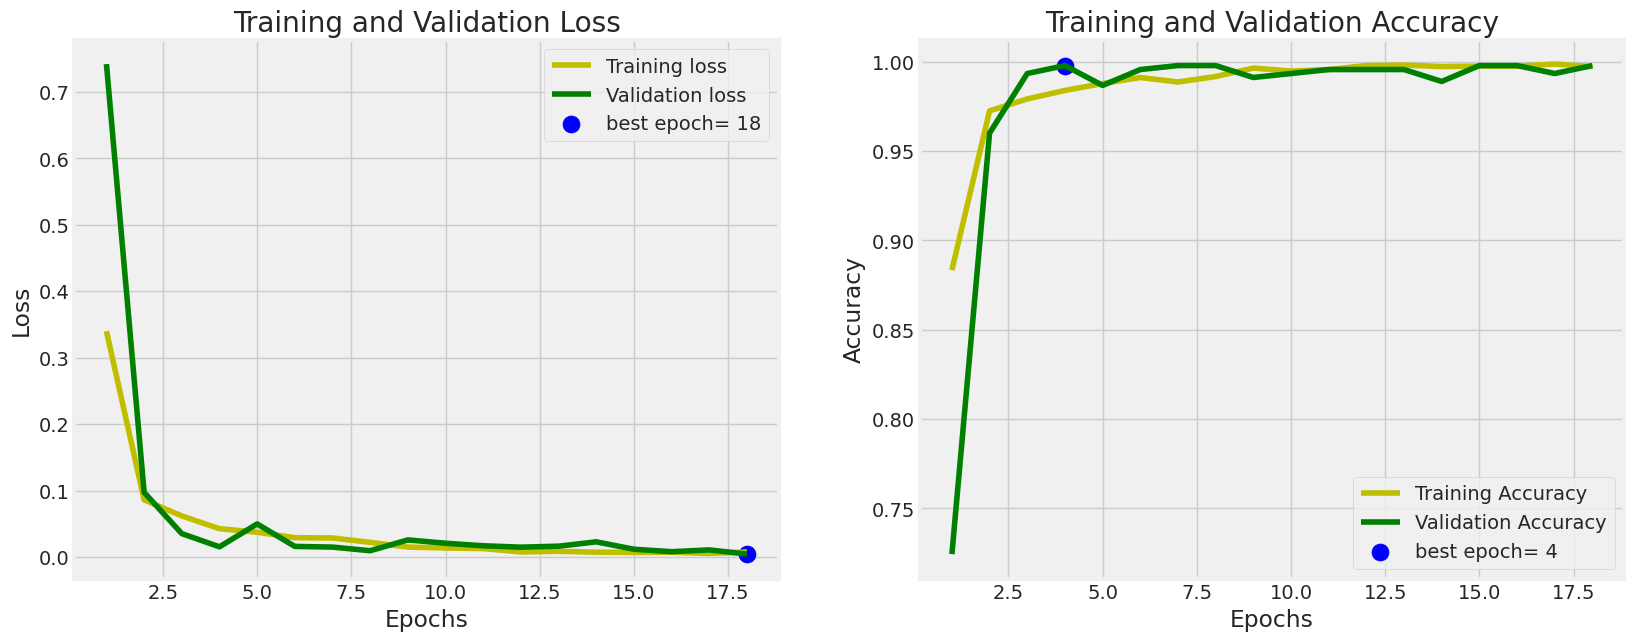

In [ ]:
def plot_training(hist):
    '''
    Fungsi ini digunakan untuk menampilkan grafik riwayat akurasi dan loss dari proses training model.
    '''

    # Variabel yang dibutuhkan
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot riwayat training
    plt.figure(figsize= (20, 7))
    plt.style.use('fivethirtyeight')

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'y', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Akurasi
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'y', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# Tampilkan grafik pelatihan
plot_training(history)

# **4. Evaluasi**

#### 4.1 Akurasi Data Test

In [ ]:
# Batch size dan step
print("Batch size data test : ", test_batch_size)
print("Test step data test  : ", test_steps)

# Evaluasi model pada data test
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps, verbose=2)

# Menghitung akurasi dalam bentuk persen
test_acc_percent = f"{test_acc:.2%}"
print(f"\nLoss pada data test: {test_loss:.4f}")
print(f"Akurasi pada data test: {test_acc_percent}")

Batch size data test :  1
Test step data test  :  449
449/449 - 142s - loss: 0.0071 - accuracy: 0.9978 - 142s/epoch - 315ms/step

Loss pada data test: 0.0071
Akurasi pada data test: 99.78%


#### 4.2 Confusion Matrics dan Classification Report

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    """
    Fungsi ini menampilkan Confusion Matrix secara visual.

    Parameter:
        cm (array): Confusion Matrix yang akan ditampilkan.
        classes (list): Daftar nama kelas.
        normalize (bool): Pilihan untuk melakukan Normalisasi Confusion Matrix.
        title (str): Judul plot Confusion Matrix.
        cmap (colormap): Palet warna yang digunakan untuk plot.
    """

    # Membuat figure untuk plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Menampilkan Confusion Matrix sebagai gambar
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Menambahkan label sumbu x dan y dengan nama kelas
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    # Normalisasi Confusion Matrix (opsional)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('\n'+'-'*44+' Confusion Matrix Ternormalisasi '+'-'*44+'\n')
    else:
        print('\n'+'-'*42+' Confusion Matrix Tanpa Normalisasi '+'-'*42+'\n')

    # Menambahkan teks angka pada setiap kotak Confusion Matrix
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    # Menambahkan judul dan color bar
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.ylabel('Label Sebenarnya')
    plt.xlabel('Label Prediksi')

    # Menampilkan plot
    plt.show()

449/449 [==============================] - 12s 19ms/step

------------------------------------------ Confusion Matrix Tanpa Normalisasi ------------------------------------------



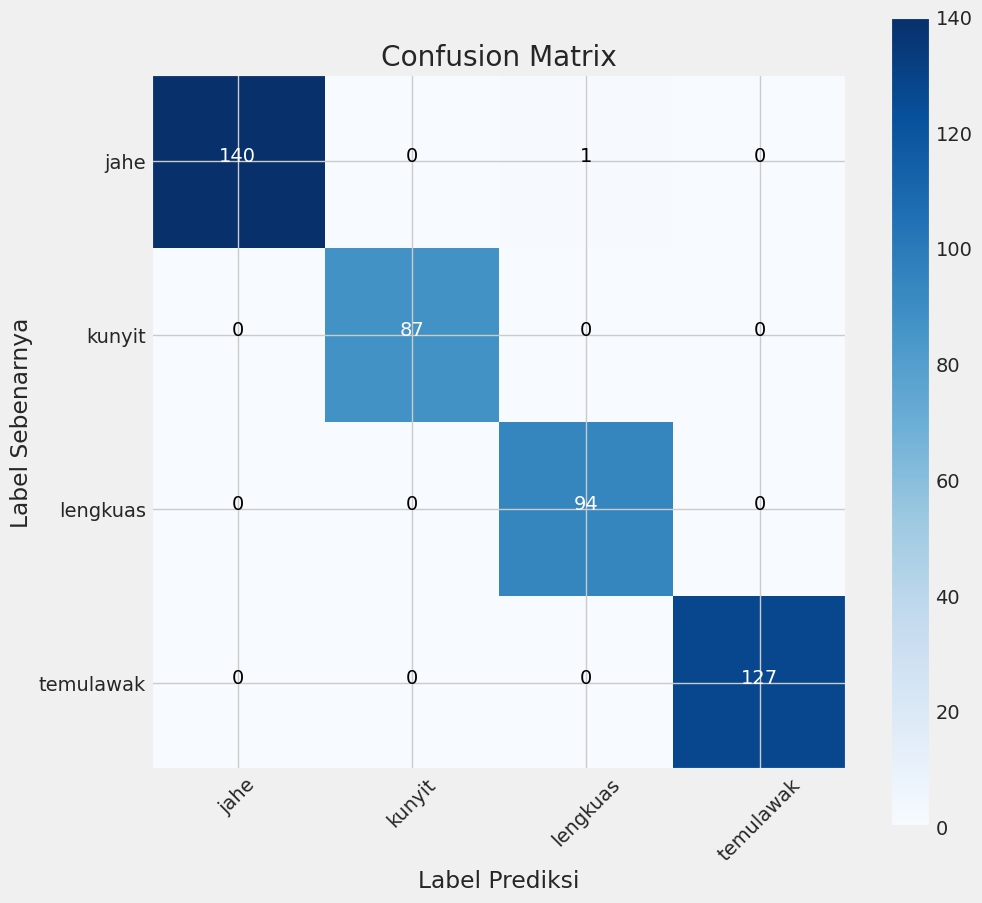


------------------ Classification Report ------------------

              precision    recall  f1-score   support

        jahe       1.00      0.99      1.00       141
      kunyit       1.00      1.00      1.00        87
    lengkuas       0.99      1.00      0.99        94
   temulawak       1.00      1.00      1.00       127

    accuracy                           1.00       449
   macro avg       1.00      1.00      1.00       449
weighted avg       1.00      1.00      1.00       449



In [ ]:
# Membuat confusion matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
classes = list(test_gen.class_indices.keys())
confusionmatrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=confusionmatrix, classes=classes, title='Confusion Matrix')

# Membuat classification report
print("\n------------------ Classification Report ------------------\n")
print(classification_report(y_true, y_pred, target_names=classes))

#### 4.3 Simpan Model

In [ ]:
subjek = 'serimpang256'
model_name = 'densenet169'
version_name = 'model1_2'

# Save model
model_name_with_acc = f"{subjek}-{model_name}-{version_name}-acc{test_acc_percent}.h5"
model.save(model_name_with_acc)
print(f"\nModel disimpan sebagai {model_name_with_acc}")

# Save weights
weights_name = f"{subjek}-{model_name}-{version_name}-weights.h5"
model.save_weights(weights_name)
print(f"\nBobot disimpan sebagai {weights_name}")


Model disimpan sebagai serimpang256-densenet169-model1_2-acc99.78%.h5

Bobot disimpan sebagai serimpang256-densenet169-model1_2-weights.h5


In [ ]:
# # Mengubah model h5 ke TFLite
# modelkonvert = tf.keras.models.load_model(model_name_with_acc)
# converter = tf.lite.TFLiteConverter.from_keras_model(modelkonvert)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()

# # Menyimpan model TFLite
# tflite_model_name = f"{model_name}-{version_name}-acc{test_acc_percent}.tflite"
# with open(tflite_model_name, "wb") as f:
#     f.write(tflite_model)

# print(f"\nModel TFLite disimpan sebagai {tflite_model_name}")

#### 4.4 Kamus Nama Kelas

In [ ]:
# Menyiapkan dictionary
class_dict = {i: class_name for i, class_name in enumerate(classes)}

# Menentukan nama file JSON
json_file_name = f"{subjek}-{version_name}-classes.json"

# Menyimpan dictionary ke file JSON
with open(json_file_name, 'w') as f:
    json.dump(class_dict, f, indent=4)

print(f"\nDictionary disimpan sebagai {json_file_name}")


Dictionary disimpan sebagai serimpang256-model1_2-classes.json
